# Functions and configuration

In [1]:
# Built-in modules
import os
import sys
from glob import glob
from datetime import datetime
from re import search, sub, findall
from time import perf_counter

# Libraries
import numpy as np
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Custom functions
sys.path.append('H:/Documents/Python Scripts')
sys.path.append('\\trinity-health.org\corp\HQ\TH\home\H\dmnb4898\Documents\Python Scripts')
from dataframe_udfs import *
from atomic_1darr_udfs import *

def fn_get_results(outcomes, estimates):
    # Function generates specificity and
    # accuracy statistics
    
    ct = pd.crosstab(estimates, outcomes)
    spec = ct.apply(lambda x: x.max()/x.sum(), axis=1)
    acc = ct.apply(lambda x: x.max(),
                   axis=1)\
        .sum()/outcomes.shape[0]
    results = {'specificity_mean': spec.mean(), 
               'specificity_std': spec.std(), 
               'accuracy': acc}
    return(results)

# Baseline

In [194]:
import collections
keys = ['method', 'specificity_mean', 'specificity_std', 'accuracy', 'time', 'exp']
Result = collections\
    .namedtuple('Result', keys)

Result.__doc__ = 'Result keys are:\
 method (e.g., \"k means\"); \
specificity_mean; \
specificity_std; \
accuracy; \
time (ie computational time); and \
exp (ie experiment)'
print(Result.__doc__)

Result keys are: method (e.g., "k means"); specificity_mean; specificity_std; accuracy; time (ie computational time); and exp (ie experiment)


Cluster sizes:
0    3334
2    3333
1    3333
dtype: int64


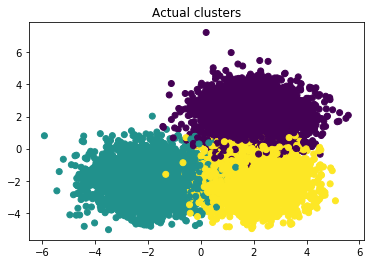

True

In [195]:
# The coordinates of the centers of our blobs.
centers = [[2, 2], [-2, -2], [2, -2]]

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.

def fn_make_gblobs(ctrs, nsamples=10000, clusterstd=1, nfeatures=2, testsize=0.9):
    X, y = make_blobs(
        n_samples=nsamples,
        centers=ctrs,
        cluster_std=clusterstd,
        n_features=nfeatures)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y,
                         test_size=testsize)
    results = {'X': X, 'X_train': X_train, 'X_test': X_test, 
               'y': y, 'y_train': y_train, 'y_test': y_test}
    return(results)

def fn_check_clusters(data_dict):
    print('Cluster sizes:')
    print(pd.Series(data_dict['y']).value_counts())
    plt.scatter(data_dict['X'][:, 0], data_dict['X'][:, 1], c=data_dict['y'])
    plt.title('Actual clusters')
    plt.show()
    return(True)

clusters = fn_make_gblobs(centers)
fn_check_clusters(clusters)


## K-means

In [196]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

K means complete, 0.045 seconds elapsed


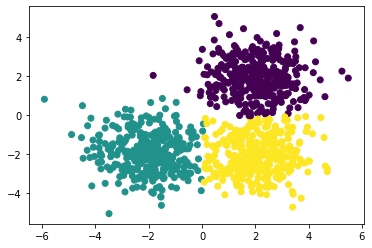

In [197]:
start = perf_counter()
km = KMeans(n_clusters=3).fit_predict(clusters['X_train'])
end = perf_counter()
print('K means complete, {0:.3f} seconds elapsed'\
     .format(end-start))

# Plot the solution.
plt.scatter(clusters['X_train'][:, 0], clusters['X_train'][:, 1], c=km)
plt.show()

# Check the solution against the data.
km_results0 = fn_get_results(clusters['y_train'], km)

In [8]:
print(km_results0)

{'specificity_mean': 0.9604277169720508, 'specificity_std': 0.012434555140855338, 'accuracy': 0.96}


In [198]:
km_result0 = Result(method='k means', 
                    specificity_mean = km_results0['specificity_mean'], 
                    specificity_std = km_results0['specificity_std'],
                    accuracy = km_results0['accuracy'],
                    time = end-start,
                    exp='baseline')
results = []
results.append(km_result0)

## Mean Shift

In [10]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
def fn_mean_shift(data):
    start = perf_counter()
    bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=500)
    
    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data)
    end = perf_counter()
    tm = end-start
    print('Mean shift clustering complete, {0:.3f} seconds elapsed'\
         .format(tm))

    # Extract cluster assignments for each data point.
    labels = ms.labels_

    # Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_

    # Count our clusters.
    n_clusters_ = len(np.unique(labels))

    print("Number of estimated clusters: {}".format(n_clusters_))
    results = {'model': ms, 'time': tm, 'y_pred': labels}
    return(results)

ms_results_raw0 = fn_mean_shift(clusters['X_train'])
ms_results0 = fn_get_results(clusters['y_train'], ms_results_raw0['y_pred'])
print(ms_results0)

ms_result0 = Result(method = 'mean shift', 
                    specificity_mean=ms_results0['specificity_mean'],
                    specificity_std=ms_results0['specificity_std'],
                    accuracy = ms_results0['accuracy'],
                    time=ms_results_raw0['time'],
                    exp='baseline')
results.append(ms_result0)

Mean shift clustering complete, 0.262 seconds elapsed
Number of estimated clusters: 3
{'specificity_mean': 0.9565900736628733, 'specificity_std': 0.01553735772669165, 'accuracy': 0.956}


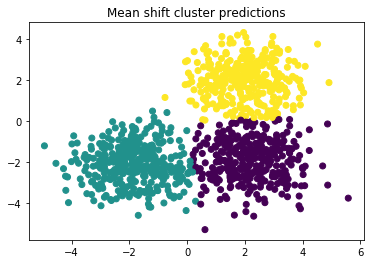

In [11]:
plt.scatter(clusters['X_train'][:, 0], 
            clusters['X_train'][:, 1], 
            c=ms_results_raw0['y_pred'])
plt.title('Mean shift cluster predictions')
plt.show()

## Spectral clustering

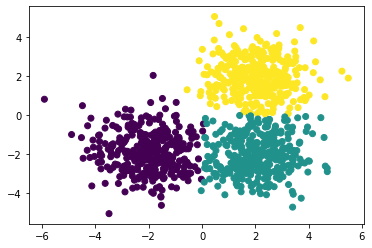

{'specificity_mean': 0.9761630889501888, 'specificity_std': 0.012514457107430415, 'accuracy': 0.976}


In [199]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
def fn_spec_clust(data, n_clusters=3):
    # Declare and fit the model.
    start = perf_counter()
    sc = SpectralClustering(n_clusters=n_clusters)
    sc.fit(data)

    #Predicted clusters.
    predict=sc.fit_predict(data)
    end = perf_counter()

    #Graph results.
    plt.scatter(data[:, 0], data[:, 1], c=predict)
    plt.show()
    results = {'model': sc, 
               'time':end-start, 
               'y_pred': predict}
    return(results)

sc_results_raw0 = fn_spec_clust(clusters['X_train'], 
                            pd.Series(clusters['y'])\
                                .drop_duplicates()\
                                .shape[0])

sc_results0 = fn_get_results(sc_results_raw0['y_pred'], 
                            clusters['y_train'])
print(sc_results0)

In [200]:
sc_result0 = Result(method='spectral clustering',
                    specificity_mean=sc_results0['specificity_mean'],
                    specificity_std=sc_results0['specificity_std'],
                    accuracy=sc_results0['accuracy'],
                    time=sc_results_raw0['time'],
                    exp='baseline')
# results.append(sc_result0)

## Affinity propogation

In [14]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.

def fn_affinity_prop(data):
    start = perf_counter()
    af = AffinityPropagation()\
        .fit(data)
    end = perf_counter()

    # Pull the number of clusters and cluster assignments for each data point. 
    results = {'model': af, 
               'time': end-start, 
               'y_pred': af.labels_,
               'n_clusters': len(af.cluster_centers_indices_),
               'cluster_centers_indices': af.cluster_centers_indices_
              }
    return(results)

ap_results_raw0 = fn_affinity_prop(clusters['X_train'])
print(ap_results_raw0.keys())

dict_keys(['model', 'time', 'y_pred', 'n_clusters', 'cluster_centers_indices'])


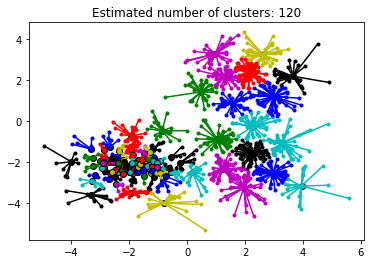

In [15]:
from itertools import cycle

def fn_plot_affinity(data, n_clusters, center_indices, y_pred):
    plt.figure(1)
    plt.clf()

    # Cycle through each cluster and graph them with a center point for the
    # exemplar and lines from the exemplar to each data point in the cluster.
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters), colors):
        class_members = y_pred == k
        cluster_center = data[center_indices[k]]
        plt.plot(data[class_members, 0], data[class_members, 1], col + '.')
        plt.plot(cluster_center[0],
                 cluster_center[1],
                 'o',
                 markerfacecolor=col,
                 markeredgecolor='k')
        for x in data[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters: {}'.format(n_clusters))
    plt.show()
    
fn_plot_affinity(clusters['X_train'], 
                 ap_results_raw0['n_clusters'],
                 ap_results_raw0['cluster_centers_indices'],
                 ap_results_raw0['y_pred'])

In [18]:
ap_results0 = fn_get_results(clusters['y_train'], ap_results_raw0['y_pred'])
print(ap_results0)

ap_result0 = Result(method = 'affinity propogation',
                     specificity_mean = ap_results0['specificity_mean'],
                     specificity_std=ap_results0['specificity_std'], 
                     accuracy=ap_results0['accuracy'],
                     time=ap_results_raw0['time'],
                     exp='baseline')

{'specificity_mean': 0.9691053654673476, 'specificity_std': 0.1014965408965866, 'accuracy': 0.947}


In [19]:
base_results = (km_result0,
                ms_result0,
                sc_result0,
                ap_result0)
print(base_results)

(Result(method='k means', specificity_mean=0.9604277169720508, specificity_std=0.012434555140855338, accuracy=0.96, time=0.05589100000000258, exp='baseline'), Result(method='mean shift', specificity_mean=0.9565900736628733, specificity_std=0.01553735772669165, accuracy=0.956, time=0.2622221999999965, exp='baseline'), Result(method='spectral clustering', specificity_mean=0.955224602387937, specificity_std=0.027395026907933023, accuracy=0.955, time=-25.3397863, exp='baseline'), Result(method='affinity propogation', specificity_mean=0.9691053654673476, specificity_std=0.1014965408965866, accuracy=0.947, time=13.041243700000024, exp='baseline'))


# Experiment 1: 3 isotropic Gaussian clusters, closer together
**Changes:**
- Clusters are closer together (2.83 units as opposed to 5.66 units)
- More points in training dataset


**Hypotheses:**
- Specificity for all methods should decrease due to poorer cluster resolution
- Computation time differences should become more pronounced between methods due to larger dataset

In [21]:
centers = np.array(centers)

In [22]:
def euc_dist(x,y):
    x = pd.Series(x)
    y = pd.Series(y)
    df = pd.DataFrame({'x':x, 'y':y})
    results = df.apply(lambda r: (r['x'] - r['y'])**2,
                       axis=1)\
        .sum()**0.5
    return(results)

print('Euclidian distance between points for original clusters: {0:.3f}'\
      .format(
    euc_dist(centers[0, :], centers[1, :])))

Euclidian distance between points for original clusters: 5.657


Euclidian distance between new clusters centers: 2.828
Cluster sizes:
0    3334
2    3333
1    3333
dtype: int64


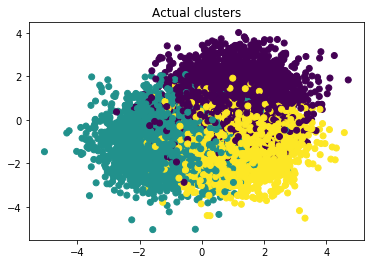

True

In [23]:
centers_new = np.array(centers)/2
dist=euc_dist(centers_new[0, :], centers_new[1, :])
print('Euclidian distance between new clusters centers: {0:.3f}'\
      .format(dist))

# fn_make_gblobs(ctrs, nsamples=10000, clusterstd=1, nfeatures=2, testsize=0.9)
clusters = fn_make_gblobs(centers_new, testsize=0.3)
fn_check_clusters(clusters)

We can see already that the blobs are much more intermingled.

## K means

In [24]:
'''
Define experiment parameters
'''
exp = 1
exp_params = {'clusters': len(centers), 
              'cluster_dist': dist,
              'isotropic': True, 
              'distribution': {'name': 'Gaussian', 'standard_dev': 1},
              'training_size': clusters['X_train'].shape[0]}

K means complete, 0.187 seconds elapsed


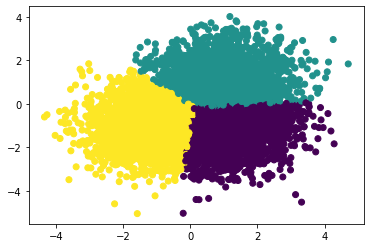

Result(method='k means', specificity_mean=0.7699636413753348, specificity_std=0.03656140188741803, accuracy=0.7712857142857142, time=0.1868387000000098, exp=1)


In [25]:
start = perf_counter()
km = KMeans(n_clusters=3).fit_predict(clusters['X_train'])
end = perf_counter()
print('K means complete, {0:.3f} seconds elapsed'\
     .format(end-start))

# Plot the solution.
plt.scatter(clusters['X_train'][:, 0], 
            clusters['X_train'][:, 1], c=km)
plt.show()

# Check the solution against the data.
km_results1 = fn_get_results(clusters['y_train'], km)
km_result1 = Result(method='k means',
                    specificity_mean=km_results1['specificity_mean'],
                    specificity_std = km_results1['specificity_std'],
                    accuracy=km_results1['accuracy'],
                    time=end-start,
                    exp = 1)

print(km_result1)

## Mean shift clustering

Mean shift clustering complete, 2.821 seconds elapsed
Number of estimated clusters: 1
{'specificity_mean': 0.3367142857142857, 'specificity_std': nan, 'accuracy': 0.3367142857142857}


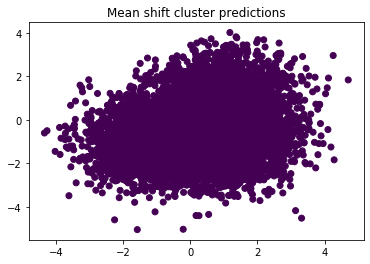

In [47]:
ms_results_raw1 = fn_mean_shift(clusters['X_train'])
ms_results1 = fn_get_results(clusters['y_train'], ms_results_raw1['y_pred'])
print(ms_results1)

ms_result1 = Result(method = 'mean shift', 
                    specificity_mean=ms_results1['specificity_mean'],
                    specificity_std=ms_results1['specificity_std'],
                    accuracy = ms_results1['accuracy'],
                    time=ms_results_raw1['time'],
                    exp='baseline')

plt.scatter(clusters['X_train'][:, 0], 
            clusters['X_train'][:, 1], 
            c=ms_results_raw1['y_pred'])
plt.title('Mean shift cluster predictions')
plt.show()

## Spectral clustering

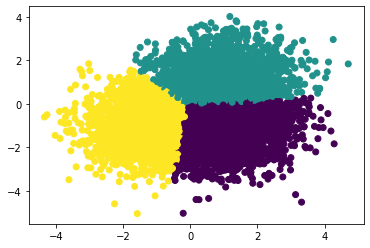

{'specificity_mean': 0.7666956684174475, 'specificity_std': 0.027993457340927543, 'accuracy': 0.7665714285714286}


In [32]:
sc_results_raw1 = fn_spec_clust(clusters['X_train'], 3)
sc_results1 = fn_get_results(sc_results_raw1['y_pred'], 
                            clusters['y_train'])
sc_result1 = Result(method="spectral clustering",
                    specificity_mean=sc_results1['specificity_mean'],
                    specificity_std=sc_results1['specificity_std'],
                    accuracy=sc_results1['accuracy'],
                    time=sc_results_raw1['time'],
                    exp=1)
print(sc_results1)

## Affinity propogation

dict_keys(['model', 'time', 'y_pred', 'n_clusters', 'cluster_centers_indices'])


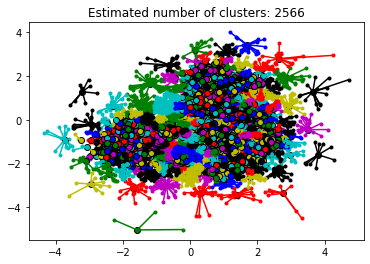

{'specificity_mean': 0.9605141998195226, 'specificity_std': 0.11947032393089199, 'accuracy': 0.8338571428571429}


In [40]:
ap_results_raw1 = fn_affinity_prop(clusters['X_train'])
print(ap_results_raw1.keys())

fn_plot_affinity(clusters['X_train'], 
                 ap_results_raw1['n_clusters'],
                 ap_results_raw1['cluster_centers_indices'],
                 ap_results_raw1['y_pred'])

ap_results1 = fn_get_results(clusters['y_train'], ap_results_raw1['y_pred'])
print(ap_results1)

ap_result1 = Result(method = 'affinity propogation',
                     specificity_mean = ap_results1['specificity_mean'],
                     specificity_std=ap_results1['specificity_std'], 
                     accuracy=ap_results1['accuracy'],
                     time=ap_results_raw1['time'],
                     exp='baseline')

In [48]:
# results = list(base_results)
results.extend([km_result1,
                ms_result1,
                sc_result1,
                ap_result1])

# Experiment 2: Gaussain distributed clusters with different standard deviations
Features of new clusters
- Gaussian clusters have different standard deviations: 0.5, 1, and 2 meaning they are non-isotropic
- Clusters are farther apart to simulate better resolution than in experiment 1
- Clusters contain the same number of points

Hypotheses
- K means: I think K means expects identical distribution among the clusters. If this is true, K means will most likely perform worse compared to baseline, possibly also compared to experiment 1.
- Mean shift: Mean shift seems to have trouble identifying clusters that have poor resolution. It should perform better than in experiment 1 since there should be more separation between clusters. It will probably perform worse than baseline due to overlap between overlapping clusters.
- Spectral clustering: Spectral clustering should perform the best since we will input the number of clusters and the method does not assume identical standard deviation--or, in fact, a Gaussian distribution.
- Affinity propogation: Affinity propogation may perform best after spectral clustering due to producing tiny clusters, as opposed to drawing broad boundries between clusters.

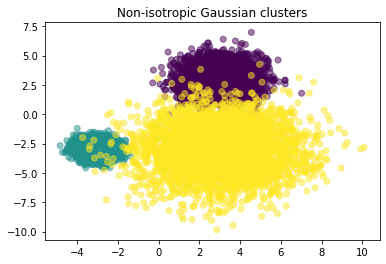


8,999 training records


In [86]:
nsamples = 3333

ctr_std= {(3, 3): 1,
          (-3,-3): 0.5,
          (3,-3): 2}

clusters = list(map(lambda a: make_blobs(
    n_samples=nsamples,
    centers=[a[0]],
    cluster_std=a[1],
    n_features=2),
         ctr_std.items()
        ))

clusters = list(map(lambda x: pd.DataFrame(x[0], columns=['f1', 'f2']), clusters))
clusters = list(map(
    lambda x: pd.concat([x[1],
                         pd.Series([x[0]]*nsamples, name='cluster')],
                       axis=1), 
         zip(np.arange(3), clusters)))

clusters = pd.concat(clusters)

plt.scatter(clusters['f1'], clusters['f2'], c=clusters['cluster'], alpha=0.5)
plt.title('Non-isotropic Gaussian clusters')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    clusters[['f1', 'f2']], 
    clusters['cluster'],
    test_size=0.1)

print('\n{0:,} training records'\
      .format(y_train.shape[0]))

## K means

K means complete, 0.142 seconds elapsed


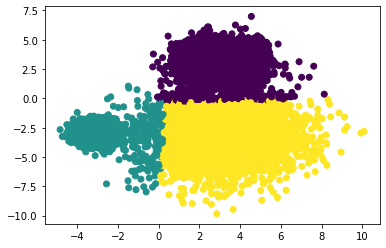

In [95]:
start = perf_counter()
km2 = KMeans(n_clusters=3).fit_predict(X_train)
end = perf_counter()
print('K means complete, {0:.3f} seconds elapsed'\
     .format(end-start))

# Plot the solution.
plt.scatter(X_train.loc[:, 'f1'], X_train.loc[:, 'f2'], c=km2)
plt.show()

# Check the solution against the data.
km_results2 = fn_get_results(y_train, km2)

km_result2 = Result(method='k means', 
                    specificity_mean = km_results2['specificity_mean'], 
                    specificity_std = km_results2['specificity_std'],
                    accuracy = km_results2['accuracy'],
                    time = end-start,
                    exp='baseline')

## Mean shift

Mean shift clustering complete, 0.828 seconds elapsed
Number of estimated clusters: 3
{'specificity_mean': 0.9598654324682867, 'specificity_std': 0.033780153253995, 'accuracy': 0.9574397155239471}


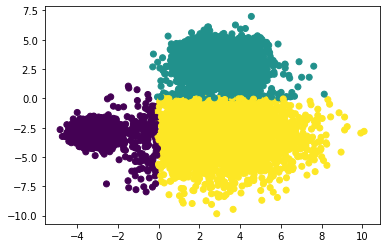

In [101]:
ms_results_raw2 = fn_mean_shift(X_train)
ms_results2 = fn_get_results(y_train, ms_results_raw2['y_pred'])
print(ms_results2)

plt.scatter(X_train.loc[:, 'f1'], X_train.loc[:, 'f2'], c=ms_results_raw2['y_pred'])

ms_result2 = Result(method = 'mean shift', 
                    specificity_mean=ms_results2['specificity_mean'],
                    specificity_std=ms_results2['specificity_std'],
                    accuracy = ms_results2['accuracy'],
                    time=ms_results_raw2['time'],
                    exp='baseline')

## Spectral clustering

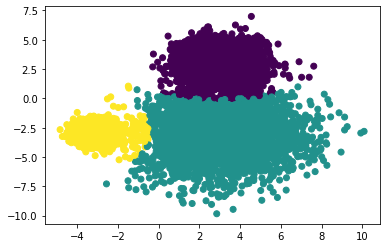

{'specificity_mean': 0.9700318838249874, 'specificity_std': 0.050762056599183474, 'accuracy': 0.9699966662962551}


In [109]:
sc_results_raw2 = fn_spec_clust(X_train.values, 3)

sc_results2 = fn_get_results(sc_results_raw2['y_pred'], 
                            y_train)
print(sc_results2)

sc_result2 = Result(method='spectral clustering',
                    specificity_mean=sc_results2['specificity_mean'],
                    specificity_std=sc_results2['specificity_std'],
                    accuracy=sc_results2['accuracy'],
                    time=sc_results_raw2['time'],
                    exp='baseline')

## Affinity propogation

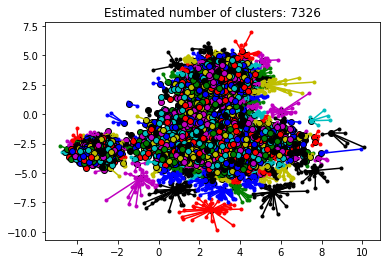

{'specificity_mean': 0.9992308707801484, 'specificity_std': 0.015713963791098663, 'accuracy': 0.9954439382153573}


In [110]:
ap_results_raw2 = fn_affinity_prop(X_train.values)

fn_plot_affinity(X_train.values, 
                 ap_results_raw2['n_clusters'],
                 ap_results_raw2['cluster_centers_indices'],
                 ap_results_raw2['y_pred'])

ap_results2 = fn_get_results(y_train.values, ap_results_raw2['y_pred'])
print(ap_results2)

ap_result2 = Result(method = 'affinity propogation',
                     specificity_mean = ap_results2['specificity_mean'],
                     specificity_std=ap_results2['specificity_std'], 
                     accuracy=ap_results2['accuracy'],
                     time=ap_results_raw2['time'],
                     exp='baseline')

In [119]:
columns = ['method', 'specificity_mean', 'specificity_std', 'accuracy', 'time_sec', 'exp']
exp2_results = pd.DataFrame([km_result2,
                             ms_result2,
                             sc_result2,
                             ap_result2],
                            columns = columns)

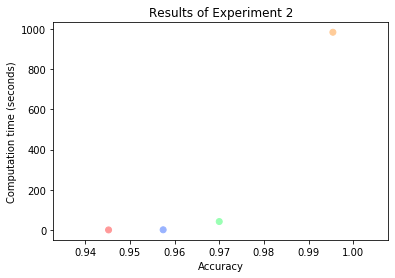

I can't figure out how to generate a legend, but from least to most accurate: K means, mean shift, spectral clustering, and affinity propogation.


In [143]:
from matplotlib import ticker
exp2_results['time_min'] = exp2_results['time_sec']/60
exp2_results['gain'] = exp2_results['accuracy'] - exp2_results['accuracy'].min()
exp2_results['gain_per_sec'] = exp2_results['gain']/exp2_results['time_sec']
exp2_results

plt.scatter(exp2_results['accuracy'],
            exp2_results['time_sec'],
            c=['#ff9999', '#99b3ff', '#99ffb3', '#ffcc99'])
plt.xlabel('Accuracy')
plt.ylabel('Computation time (seconds)')
plt.title('Results of Experiment 2')
plt.show()

print('I can\'t figure out how to generate a legend, but from least to most accurate: K means, mean shift, spectral clustering, and affinity propogation.')

## Experiment 2 conclusions
All methods performed better than I expected, particularly K means. I attribute this to the clusters being better separated than I realized. Affinity propogation did indeed achieve the highest accuracy of >0.99, but it also took over 16 minutes to run, compared to under two minutes from spectral clustering, which produced the next best accuracy of over 0.97.

# Experiment 3: Anisotropic clusters

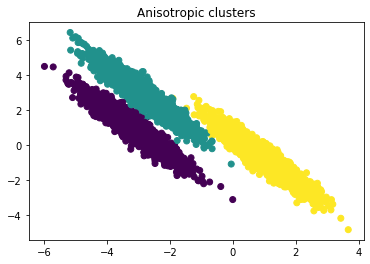

In [150]:
# Anisotropicly distributed data
from sklearn import cluster, datasets

n_samples = 10000
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
plt.title('Anisotropic clusters')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_aniso, y, test_size=0.3)

## K means

K means complete, 0.185 seconds elapsed


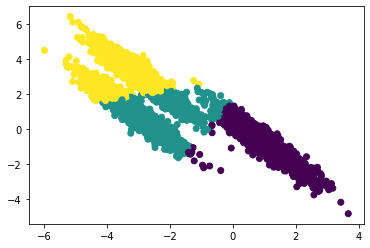

Result(method='k means', specificity_mean=0.837011632961007, specificity_std=0.1360629270662796, accuracy=0.8357142857142857, time=0.18524069999693893, exp='baseline')


In [152]:
start = perf_counter()
km3 = KMeans(n_clusters=3).fit_predict(X_train)
end = perf_counter()
print('K means complete, {0:.3f} seconds elapsed'\
     .format(end-start))

# Plot the solution.
plt.scatter(X_train[:, 0], X_train[:, 1], c=km3)
plt.show()

# Check the solution against the data.
km_results3 = fn_get_results(y_train, km3)

km_result3 = Result(method='k means', 
                    specificity_mean = km_results3['specificity_mean'], 
                    specificity_std = km_results3['specificity_std'],
                    accuracy = km_results3['accuracy'],
                    time = end-start,
                    exp='baseline')
print(km_result3)

In [159]:
km_ct = pd.crosstab(km3, y_train)
km_sens = km_ct.apply(lambda x: x.max()/x.sum(), axis=0)
km_spec = km_ct.apply(lambda x: x.max()/x.sum(), axis=1)
print(km_ct)
print(km_sens)
print(km_spec)

col_0     0     1     2
row_0                  
0        13     4  2285
1      1774   542    80
2       509  1791     2
col_0
0    0.772648
1    0.766367
2    0.965357
dtype: float64
row_0
0    0.992615
1    0.740401
2    0.778019
dtype: float64


### bservations
K means performs far better for one cluster compared to the other two clusters with a sensitivity of 0.965 and specificity of 0.993. The other two clusters have the following values:
- Alternate cluster 1: sensitivity=0.773, specificity=0.740
- Altrnate cluster 2: sensitivity=0.766, specificity=0.778

These aren't as terrible as they could be but they're certainly not the results we saw in baseline conditions and experiment 2.

## Mean shift

Mean shift clustering complete, 1.296 seconds elapsed
Number of estimated clusters: 2
{'specificity_mean': 0.7315412868211673, 'specificity_std': 0.3133035836031445, 'accuracy': 0.6651428571428571}


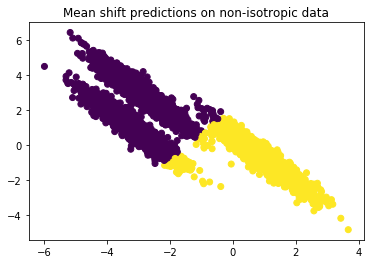

In [164]:
ms_results_raw3 = fn_mean_shift(X_train)
ms_results3 = fn_get_results(y_train, ms_results_raw3['y_pred'])
print(ms_results3)

plt.scatter(X_train[:, 0], X_train[:, 1], c=ms_results_raw3['y_pred'])
plt.title('Mean shift predictions on non-isotropic data')
plt.show()

ms_result3 = Result(method = 'mean shift', 
                    specificity_mean=ms_results3['specificity_mean'],
                    specificity_std=ms_results3['specificity_std'],
                    accuracy = ms_results3['accuracy'],
                    time=ms_results_raw3['time'],
                    exp='baseline')

## Spectral clustering

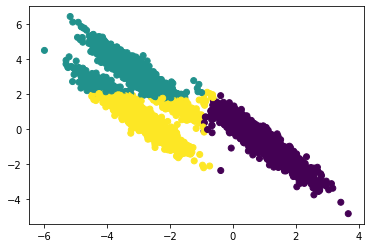

{'specificity_mean': 0.9081302988787723, 'specificity_std': 0.07269731832547967, 'accuracy': 0.9087142857142857}


In [166]:
sc_results_raw3 = fn_spec_clust(X_train, 3)

sc_results3 = fn_get_results(sc_results_raw3['y_pred'], 
                            y_train)
print(sc_results3)

sc_result3 = Result(method='spectral clustering',
                    specificity_mean=sc_results3['specificity_mean'],
                    specificity_std=sc_results3['specificity_std'],
                    accuracy=sc_results3['accuracy'],
                    time=sc_results_raw3['time'],
                    exp='baseline')

In [182]:
sc_ct = pd.crosstab(pd.Series(sc_results_raw3['y_pred'], name='Predicted'), 
                    pd.Series(y_train, name='Actual'))
ind = pd.Series([2, 1, 0], name='Predicted')
sc_ct.index = ind

sens = sc_ct.apply(lambda x: x.max()/x.sum(), axis=0)
spec = sc_ct.apply(lambda x: x.max()/x.sum(), axis=1)

sc_met3 = pd.DataFrame()
sc_met3['sensitivity'] = sens
sc_met3['specificity'] = spec

print(sc_ct)
print()
print(sc_met3)

Actual        0     1     2
Predicted                  
2             1    10  2348
1           298  2016     6
0          1997   311    13

        sensitivity  specificity
Actual                          
0          0.869774     0.860405
1          0.862644     0.868966
2          0.991973     0.995337


### Observation
Spectral clustering performed better than mean shift but not as well as I was expecting. Still, the lowest sensitivity is 0.863 and the lowest specificity is 0.860, which is still significantly better than the other methods used so far.

## Affinity propogation

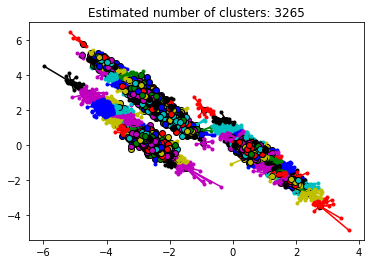

{'specificity_mean': 0.9993159775395609, 'specificity_std': 0.015355104904051264, 'accuracy': 0.9987142857142857}


In [184]:
ap_results_raw3 = fn_affinity_prop(X_train)

fn_plot_affinity(X_train, 
                 ap_results_raw3['n_clusters'],
                 ap_results_raw3['cluster_centers_indices'],
                 ap_results_raw3['y_pred'])

ap_results3 = fn_get_results(y_train, ap_results_raw3['y_pred'])
print(ap_results3)

ap_result3 = Result(method = 'affinity propogation',
                     specificity_mean = ap_results3['specificity_mean'],
                     specificity_std=ap_results3['specificity_std'], 
                     accuracy=ap_results3['accuracy'],
                     time=ap_results_raw3['time'],
                     exp='baseline')

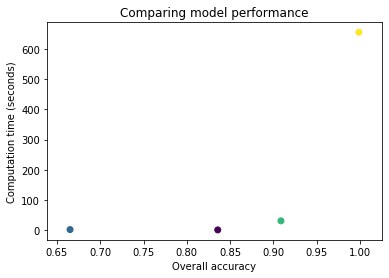

Model performance from least to most accurate: mean shift, k menas, spectral clustering, and affinity propogation.


In [189]:
exp3 = pd.DataFrame([km_result3,
                     ms_result3,
                     sc_result3,
                     ap_result3], columns =columns)
exp3

plt.scatter(exp3['accuracy'], exp3['time_sec'], c=np.arange(4))
plt.title('Comparing model performance')
plt.xlabel('Overall accuracy')
plt.ylabel('Computation time (seconds)')
plt.show()
print('Model performance from least to most accurate: mean shift, k menas, spectral clustering, and affinity propogation.')

### Experiment 3 conclusions
Once again, affinity propogation exhibited the highest accuracy at the expense of a run time much, much longer than any of hte others. Spectral clustering required 30 seconds to run and achieved an accuracy of over 0.9. Mean shift performed the worst by far, only achieving an accuracy of a 0.66.

# Conclusions

In [201]:
results = pd.DataFrame([km_result0, km_result1, km_result2, km_result3,
           ms_result0, ms_result1, ms_result2, ms_result3,
           sc_result0, sc_result1, sc_result2, sc_result3,
           ap_result0, ap_result1, ap_result2, ap_result3],
                       columns = columns)

                      accuracy    time_sec
method                                    
affinity propogation  0.943754  568.370289
k means               0.881804    0.139733
mean shift            0.728824    1.301578
spectral clustering   0.905321   25.746470


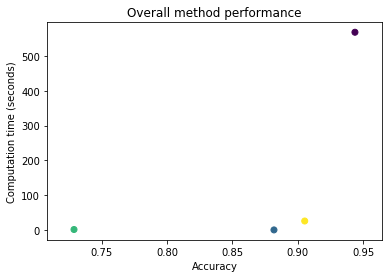

In [208]:
results['exp'] = [0,1,2,3]*4
results_summ = results\
    .groupby('method')[['accuracy', 'time_sec']]\
    .apply(lambda x: x.mean())
print(results_summ)

plt.scatter(results_summ['accuracy'], results_summ['time_sec'], c=np.arange(4))
plt.title('Overall method performance')
plt.xlabel('Accuracy')
plt.ylabel('Computation time (seconds)')
plt.show()

As we saw throughout the experiments, affinity propogation performed best overall at the expense of much longer computational times. Spectral clustering performed best after affinity propogation with only slightly longer computation time required. Affinity propogation performed the worst. However, in this particular case we had the advantage of knowing how many clusters objectively existed and were able to feed this to the K means and spectral clustering models. In the real world means shift may outperform those algorithms due to its ability to infer the number of clusters.

All of the algorithms suffered when the clusters were anisotropic aside from affinity propogation, though spectral clustering outperformed K means and mean shift. I don't know what this means for the real world where we won't know the distribution of the data going into the analysis. At this point I don't feel confident that I would know how to test a dataset to determine whether the features I'm interested in using in my clustering analysis are Gaussian "enough".

One final note about affinity propogation. In this experiment we were only interested in accuracy on the training dataset. It seems likely that affinity propogation tends to overfit. Even if we aren't using affinity propogation as a classifier per se, if we're using clustering as part of a predictive model we would want to be confident that unseen records would still exhibit the same generall connectivity and compactness.